In [1]:
import os

def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []

    # Map subdirectories to labels
    label_mapping = {'Original': 0, 'Digital': 1}

    for label_name, label in label_mapping.items():
        # Get the full path of the subdirectory
        label_dir = os.path.join(data_dir, label_name)

        # Iterate over each file in the subdirectory
        for filename in os.listdir(label_dir):
            # Only add files with image extensions
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                # Append the path and label
                image_paths.append(os.path.join(label_dir, filename))
                labels.append(label)

    return image_paths, labels

# Example usage
data_dir = '/content/drive/MyDrive/ml/Notebook_Data/'  # Path to your main directory
data_image_paths, data_labels = get_image_paths_and_labels(data_dir)

# Check the results
print("Image Paths:", data_image_paths)
print("Labels:", data_labels)


Image Paths: ['/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_162307.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_162824.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_162831.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_162849.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_162903.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_162917.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_163040.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_163050.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_163101.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_163113.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_163233.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_163240.jpg', '/content/drive/MyDrive/ml/Notebook_Data/Original/IMG_20241113_163257.jpg'

#### Download Holistic Edge Detection pre-trained model and Deploy.prototxt from [here](https://www.kaggle.com/code/baskarsettu/holistic-edge-detection)

In [2]:
import cv2

# Load the pre-trained HED model
hed_prototxt_path = '/content/drive/MyDrive/ml/hed_model/deploy.prototxt'  # Update with your path
hed_model_path = '/content/drive/MyDrive/ml/hed_model/hed_pretrained_bsds.caffemodel'  # Update with your path

hed_net = cv2.dnn.readNetFromCaffe(hed_prototxt_path, hed_model_path)

def apply_hed_detection(image):
    """
    Apply HED edge detection on the input image.
    """
    # Resize the image to the HED model's expected input size
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(img_width, img_height),
                                 mean=(104.00698793, 116.66876762, 122.67891434), swapRB=False, crop=False)
    hed_net.setInput(blob)
    edges = hed_net.forward()
    edges = edges[0, 0, :, :]  # Extract the 2D edge map
    edges = (255 * edges).astype(np.uint8)  # Convert to 8-bit
    return edges

In [3]:
#import cv2
#import numpy as np
#from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

#edge detection
#def apply_edge_detection(image):
 #   gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 #   edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
  #  return edges


In [4]:
#frequency
def apply_frequency_analysis(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    f_transform = np.fft.fft2(gray_image)
    f_shift = np.fft.fftshift(f_transform)  # Center the low frequencies
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)  # Log scale to visualize
    return np.uint8(magnitude_spectrum)  # Normalize to 8-bit


In [5]:
from skimage.feature import local_binary_pattern

# texture
def apply_texture_analysis(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 1  # Radius for LBP calculation
    n_points = 8 * radius  # Number of circularly symmetric neighbor set points
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp = (lbp / lbp.max()) * 255  # Normalize to 8-bit
    return lbp.astype(np.uint8)


In [6]:
def preprocess_image(image_path):
    # Load and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (img_width, img_height))

    # Apply preprocessing steps
    edges = apply_hed_detection(image)
    frequency = apply_frequency_analysis(image)
    texture = apply_texture_analysis(image)

    # Stack all channels
    processed_image = np.stack([image[:, :, 0],edges, frequency, texture], axis=-1)
    return processed_image


In [7]:
import tensorflow as tf
import numpy as np

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.classes = np.array(labels)
        self.img_size = img_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.array([preprocess_image(path) for path in batch_paths])
        return images, np.array(batch_labels)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        np.random.shuffle(self.indices)
        self.image_paths = [self.image_paths[i] for i in self.indices]
        self.labels = [self.labels[i] for i in self.indices]


In [8]:
from sklearn.model_selection import train_test_split

# Assuming train_image_paths and train_labels are already created
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    data_image_paths, data_labels, test_size=0.25, random_state=42, stratify=data_labels, shuffle=True)

In [9]:
len(train_image_paths)

72

In [10]:
len(val_image_paths)

24

In [11]:
batch_size = 8
img_height = 400
img_width = 300

# Initialize data generators
train_generator = CustomDataGenerator(train_image_paths, train_labels, batch_size, (img_height, img_width))
val_generator = CustomDataGenerator(val_image_paths, val_labels, batch_size, (img_height, img_width))


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
def build_cnn_model(input_shape=(img_height, img_width, 4)):  # 4 channels instead of 3
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_model()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 398, 298, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 199, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 197, 147, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 98, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 46, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 21, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 7, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8960)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,147,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,286,849 (4.91 MB)

 Trainable params: 1,286,849 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs = 15
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 215s 12s/step - accuracy: 0.3858 - loss: 40.8622 - val_accuracy: 0.5833 - val_loss: 0.6611
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 218s 9s/step - accuracy: 0.6484 - loss: 0.9197 - val_accuracy: 0.2500 - val_loss: 0.7145
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 194s 8s/step - accuracy: 0.4571 - loss: 0.7858 - val_accuracy: 0.5833 - val_loss: 0.6391
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.4552 - loss: 0.8916 - val_accuracy: 0.4167 - val_loss: 0.6839
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.4061 - loss: 0.7966 - val_accuracy: 0.4583 - val_loss: 0.6824
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.6432 - loss: 0.6621 - val_accuracy: 0.5833 - val_loss: 0.6662
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 221s 10s/step - accuracy: 0.5412 - loss: 0.6791 - val_accuracy: 0.5833 - val_loss: 0.6478
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.7058 - loss: 0.5981 - val_accuracy: 0.9583 - val_loss: 0.4395
Epoch 9/

In [38]:
model.evaluate(val_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - accuracy: 0.6979 - loss: 0.6069


[0.6093950271606445, 0.7083333134651184]

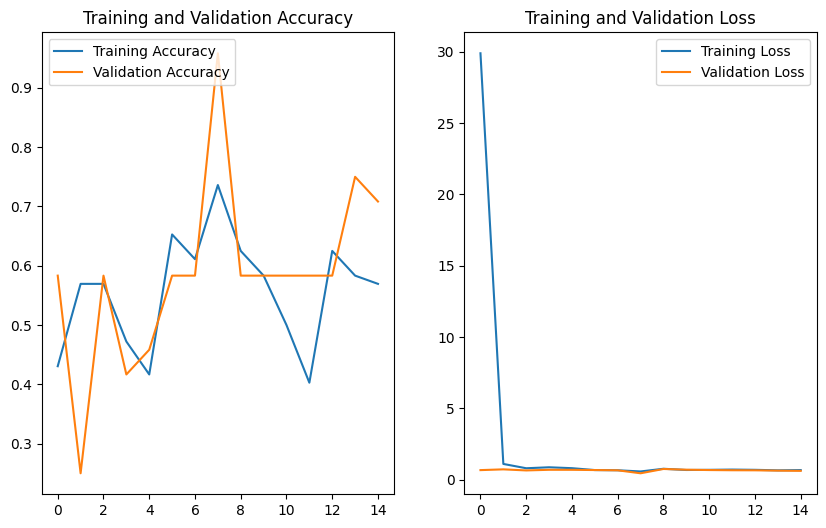

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions on validation data
test_predictions = (model.predict(val_generator) > 0.5).astype("int32")

# Calculate metrics
true_labels = val_generator.classes
print(classification_report(true_labels, test_predictions, target_names=['Original', 'Digital']))

# Confusion matrix
print(confusion_matrix(true_labels, test_predictions))


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step
              precision    recall  f1-score   support

    Original       0.71      0.86      0.77        14
     Digital       0.71      0.50      0.59        10

    accuracy                           0.71        24
   macro avg       0.71      0.68      0.68        24
weighted avg       0.71      0.71      0.70        24

[[12  2]
 [ 5  5]]


In [28]:
#Preprocess and predict the label for a single image.

def predict_single_image(image_path):
    """
    Preprocess and predict the label for a single image.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Resize the image to the required input size
    image = cv2.resize(image, (img_width, img_height))

    # Apply preprocessing
    edges = apply_hed_detection(image)
    frequency = apply_frequency_analysis(image)
    texture = apply_texture_analysis(image)

    # Stack the channels
    processed_image = np.stack([image[:, :, 0], edges, frequency, texture], axis=-1)

    # Add batch dimension
    processed_image = np.expand_dims(processed_image, axis=0)  # Shape: (1, img_height, img_width, 4)

    # Predict the label
    prediction = model.predict(processed_image)[0]

    # Interpret the prediction
    label = "Original" if prediction < 0.5 else "Digital"

    return label

# Path to the single image
single_image_path = '/content/drive/MyDrive/ml/test_notebook/4.jpg'  # Replace with the actual image path

# Predict
label = predict_single_image(single_image_path)

# Display the result
print(f"Image: {single_image_path}")
print(f"Predicted Label: {label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Image: /content/drive/MyDrive/ml/test_notebook/4.jpg
Predicted Label: Original


In [36]:
# To Test on batch

# Define a function to preprocess images for testing
def preprocess_single_image(image_path):
    """
    Preprocess a single image to match the input shape for the model.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    image = cv2.resize(image, (img_width, img_height))  # Resize to the required dimensions

    # Apply preprocessing steps
    edges = apply_hed_detection(image)
    frequency = apply_frequency_analysis(image)
    texture = apply_texture_analysis(image)

    # Stack all channels into a single array
    processed_image = np.stack([image[:, :, 0], edges, frequency, texture], axis=-1)

    # Add batch dimension
    processed_image = np.expand_dims(processed_image, axis=0)  # Shape: (1, img_height, img_width, 4)

    return processed_image

# Define a function to load and preprocess all images in a directory
def load_and_preprocess_images(test_dir):
    """
    Load and preprocess all images from the specified directory.
    """
    test_image_paths = [
        os.path.join(test_dir, f) for f in os.listdir(test_dir)
        if f.endswith(('.jpg', '.jpeg', '.png'))
    ]

    preprocessed_images = []
    for path in test_image_paths:
        try:
            preprocessed_image = preprocess_single_image(path)
            preprocessed_images.append(preprocessed_image[0])  # Remove the batch dimension for stacking
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return test_image_paths, np.array(preprocessed_images)  # Convert to a single NumPy array

# Directory containing new test images
test_dir = '/content/drive/MyDrive/ml/test_notebook'  # Replace with the path to your test image directory

# Load and preprocess the test images
test_image_paths, test_images = load_and_preprocess_images(test_dir)

print(f"Shape of the test images batch: {test_images.shape}")  # Check the shape

# Make predictions
predictions = model.predict(test_images)

# Display results for all images
for path, pred in zip(test_image_paths, predictions):
    label = "Original" if pred < 0.5 else "Digital"
    print(f"Image: {path}, Predicted Label: {label}")



Shape of the test images batch: (8, 400, 300, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
Image: /content/drive/MyDrive/ml/test_notebook/3.jpg, Predicted Label: Original
Image: /content/drive/MyDrive/ml/test_notebook/4.jpg, Predicted Label: Original
Image: /content/drive/MyDrive/ml/test_notebook/2.jpg, Predicted Label: Original
Image: /content/drive/MyDrive/ml/test_notebook/8.jpg, Predicted Label: Original
Image: /content/drive/MyDrive/ml/test_notebook/5.jpg, Predicted Label: Digital
Image: /content/drive/MyDrive/ml/test_notebook/6.jpg, Predicted Label: Original
Image: /content/drive/MyDrive/ml/test_notebook/7.jpg, Predicted Label: Original
Image: /content/drive/MyDrive/ml/test_notebook/1.jpg, Predicted Label: Original
